## Introduction to Image Processing:  
#### Classify handwritten digits using the famous MNIST data

The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.  As the competition progresses, we will release tutorials which explain different machine learning algorithms and help you to get started.


The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.


The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.  

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.  

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.  

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).  

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.  

Visually, if we omit the "pixel" prefix, the pixels make up the image like this:  

000 001 002 003 ... 026 027  
028 029 030 031 ... 054 055  
056 057 058 059 ... 082 083  
                ...  
728 729 730 731 ... 754 755  
756 757 758 759 ... 782 783  


The test data set, (test.csv), is the same as the training set, except that it does not contain the "label" column.

Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line containing the ImageId and the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:  

ImageId,Label
1,3
2,7
3,8 
(27997 more lines)

The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified. For example, a categorization accuracy of 0.97 indicates that you have correctly classified all but 3% of the images.  

#### Loading packages...  

In [1]:
import os
import sys
import time
import glob
import math
import random
import pickle
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties

#https://github.com/opencv/opencv
#http://www.pyimagesearch.com/2015/07/20/install-opencv-3-0-and-python-3-4-on-ubuntu/
#import cv2 

#from sklearn.utils import shuffle
#from sklearn.preprocessing import LabelEncoder
from sklearn import cross_validation
from sklearn.decomposition import PCA


#import theano
#from theano import tensor as T


%matplotlib inline
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
datapath = "../datasets/Kaggle/"
outputs = "../outputs/"

In [3]:
# read training data from CSV file 
train_data = pd.read_csv(os.path.join(datapath, "kaggle_digits_train.csv"))

print('data({0[0]},{0[1]})'.format(train_data.shape))
train_data.head()

data(42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Every image is a "stretched" array of pixel values.  
In this case it's 784 pixels => 28 * 28 px  

In [4]:
images = train_data.iloc[:,1:].values
images = images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
images = np.multiply(images, 1.0 / 255.0)

print('images({0[0]},{0[1]})'.format(images.shape))

images(42000,784)


In [5]:
image_size = images.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


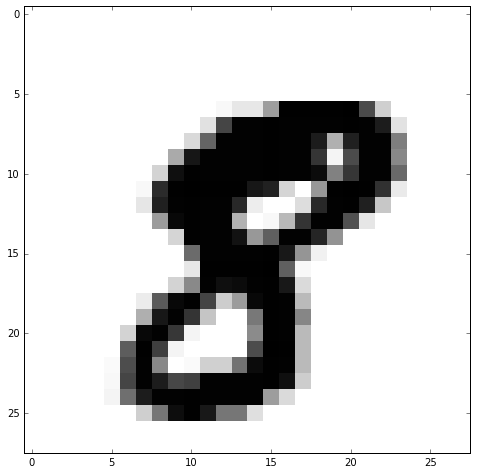

In [6]:
IMAGE_TO_DISPLAY = 10

# (784) => (28,28)
plt.imshow(images[IMAGE_TO_DISPLAY].reshape((28, 28)), cmap=cm.binary)

In [7]:
labels_flat = train_data[[0]].values.ravel()

print('labels_flat({0})'.format(len(labels_flat)))
print ('labels_flat[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels_flat[IMAGE_TO_DISPLAY]))

labels_flat(42000)
labels_flat[10] => 8


In [8]:
labels_flat

array([1, 0, 1, ..., 7, 6, 9])

In [9]:
labels_count = np.unique(labels_flat).shape[0]

print('labels_count => {0}'.format(labels_count))

labels_count => 10


In [10]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(images, 
                                                                     labels_flat, 
                                                                     test_size=0.4, 
                                                                     random_state=0)
print('train images({0[0]},{0[1]})'.format(X_train.shape))
print('validation images({0[0]},{0[1]})'.format(X_test.shape))
print('train labels({})'.format(y_train.shape))
print('validation labels({})'.format(y_test.shape))

train images(25200,784)
validation images(16800,784)
train labels((25200,))
validation labels((16800,))


In [11]:
from sklearn.ensemble import RandomForestClassifier

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_train, y_train)

eval_rf = clf_rf.score(X_test, y_test)
print(eval_rf)

0.960416666667


In [12]:
# Train SVM...
from sklearn import svm
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf_svm = svm.SVC(kernel='poly',
                  C=1.57,
                  degree=2, 
                  gamma=0.278,
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.001, 
                  cache_size=200, 
                  class_weight=None, 
                  verbose=False, 
                  max_iter=-1, 
                  random_state=0).fit(X_train, y_train)

eval_svm = clf_svm.score(X_test, y_test)
print(eval_svm)

0.972083333333


In [13]:
# Making Predictios
test_data = pd.read_csv(os.path.join(datapath, "kaggle_digits_test.csv"))
print('data({0[0]},{0[1]})'.format(test_data.shape))
test_data.head()

data(28000,784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test_data = test_data.values.astype(np.float)

In [15]:
predict_svm = clf_svm.predict(test_data)
predict_svm[0:10]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

In [16]:
predict_rf = clf_rf.predict(test_data)
predict_rf[0:10]

array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

### Using Tensor Flow  
https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html  
https://www.kaggle.com/kakauandme/digit-recognizer/tensorflow-deep-nn/  
https://www.kaggle.com/bhagyeshvikani/digit-recognizer/deep-convolutional-ann/code  (TBD)

References:  

[Deep MNIST for Experts](https://www.tensorflow.org/versions/master/tutorials/mnist/pros/index.html#deep-mnist-for-experts/ "Deep MNIST for Experts")  

[A Convolutional Network implementation example using TensorFlow library](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3%20-%20Neural%20Networks/convolutional_network.ipynb/ "A Convolutional Network implementation example using TensorFlow library")

[Digit recognizer in Python using CNN](https://www.kaggle.com/kobakhit/digit-recognizer/digit-recognizer-in-python-using-cnn/ "Digit recognizer in Python using CNN")

[Deep Learning in a Nutshell: Core Concepts](http://devblogs.nvidia.com/parallelforall/deep-learning-nutshell-core-concepts/ "Deep Learning in a Nutshell: Core Concepts")

In [17]:
import tensorflow as tf

# settings
LEARNING_RATE = 1e-4

# set to 20000 on local environment to get 0.99 accuracy
TRAINING_ITERATIONS = 2500        
DROPOUT = 0.5
BATCH_SIZE = 50

# set to 0 to train on all available data
VALIDATION_SIZE = X_test.shape[0]

For most classification problems "one-hot vectors" are used. A one-hot vector is a vector that contains a single element equal to 1 and the rest of the elements equal to 0. In this case, the nth digit is represented as a zero vector with 1 in the nth position.  

In [18]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]

def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

print('labels({0[0]},{0[1]})'.format(labels.shape))
print ('labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,labels[IMAGE_TO_DISPLAY]))

labels(42000,10)
labels[10] => [0 0 0 0 0 0 0 0 1 0]


In [19]:
# split data into training & validation
#validation_images = images[:VALIDATION_SIZE]
#validation_labels = labels[:VALIDATION_SIZE]
#train_images = images[VALIDATION_SIZE:]
#train_labels = labels[VALIDATION_SIZE:]


X_train, X_test, y_train, y_test = cross_validation.train_test_split(images, 
                                                                     labels, 
                                                                     test_size=0.4, 
                                                                     random_state=0)
print('train images({0[0]},{0[1]})'.format(X_train.shape))
print('validation images({0[0]},{0[1]})'.format(X_test.shape))
print('train labels({})'.format(y_train.shape))
print('validation labels({})'.format(y_test.shape))

train images(25200,784)
validation images(16800,784)
train labels((25200, 10))
validation labels((16800, 10))


#### TensorFlow graph  

TensorFlow does its heavy lifting outside Python. Therefore, instead of running every single operation independently, TensorFlow allows users to build a whole graph of interacting operations and then runs the workflow in a separate process at once.  

Helper functions  

For this NN model, a lot of weights and biases are created. Generally, weights should be initialised with a small amount of noise for symmetry breaking, and to prevent 0 gradients.  

Since we are using ReLU neurones (ones that contain rectifier function f(x)=max(0,x)), it is also good practice to initialise them with a slightly positive initial bias to avoid "dead neurones".  

In [20]:
# weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

For this problem we use zero padded convolutions so that the output is the same size as the input. Stride/step in this case is equal to 1.  

In general, convolution layer is used to get the features of the data. In the case of digit recognition - a shape of each digit. It uses learnable kernels/filters each of which corresponds to one particular shape pattern. The number of the filter can differ for other problems.  

In [21]:
# convolution
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

Pooling is plain max pooling over 2x2 blocks.  

Pooling is used for downsampling of the data. 2x2 max-pooling splits the image into square 2-pixel blocks and only keeps maximum value for each of those blocks.  

In [22]:
# pooling
# [[0,3],
#  [4,2]] => 4

# [[0,1],
#  [1,1]] => 1

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

The good thing about neural networks that any NN can be used as a layer in a large multilayer NN meaning that output of one can be used as input for another. This sequential approach can create very sophisticated NN with multiple layers. They are also called Deep Neural Networks.  

In this case, we use two convolution layers with pooling in between them, then densely connected layer followed by dropout and lastly readout layer.  

In [23]:
# input & output of NN

# images
x = tf.placeholder('float', shape=[None, image_size])
# labels
y_ = tf.placeholder('float', shape=[None, labels_count])

The first layer is a convolution, followed by max pooling. The convolution computes 32 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels (1 means that images are grayscale), and the last is the number of output channels. There is also a bias vector with a component for each output channel.  

To apply the layer, we reshape the input data to a 4d tensor, with the first dimension corresponding to the number of images, second and third - to image width and height, and the final dimension - to the number of colour channels.  

After the convolution, pooling reduces the size of the output from 28x28 to 14x14.  

In [24]:
# first convolutional layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# (40000,784) => (40000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
print (image.get_shape()) # =>(40000,28,28,1)


h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
print (h_conv1.get_shape()) # => (40000, 28, 28, 32)
h_pool1 = max_pool_2x2(h_conv1)
print (h_pool1.get_shape()) # => (40000, 14, 14, 32)


# Prepare for visualization
# display 32 fetures in 4 by 8 grid
layer1 = tf.reshape(h_conv1, (-1, image_height, image_width, 4 ,8))  

# reorder so the channels are in the first dimension, x and y follow.
layer1 = tf.transpose(layer1, (0, 3, 1, 4,2))

layer1 = tf.reshape(layer1, (-1, image_height*4, image_width*8))

(?, 28, 28, 1)
(?, 28, 28, 32)
(?, 14, 14, 32)


The second layer has 64 features for each 5x5 patch. Its weight tensor has a shape of [5, 5, 32, 64]. The first two dimensions are the patch size, the next is the number of input channels (32 channels correspond to 32 featured that we got from previous convolutional layer), and the last is the number of output channels. There is also a bias vector with a component for each output channel.  

Because the image is down-sampled by pooling to 14x14 size second convolutional layer picks up more general characteristics of the images. Filters cover more space of the picture. Therefore, it is adjusted for more generic features while the first layer finds smaller details.  

In [25]:
# second convolutional layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
print (h_conv2.get_shape()) # => (40000, 14,14, 64)
h_pool2 = max_pool_2x2(h_conv2)
print (h_pool2.get_shape()) # => (40000, 7, 7, 64)

# Prepare for visualization
# display 64 fetures in 4 by 16 grid
layer2 = tf.reshape(h_conv2, (-1, 14, 14, 4 ,16))  

# reorder so the channels are in the first dimension, x and y follow.
layer2 = tf.transpose(layer2, (0, 3, 1, 4,2))

layer2 = tf.reshape(layer2, (-1, 14*4, 14*16))

(?, 14, 14, 64)
(?, 7, 7, 64)


Now that the image size is reduced to 7x7, we add a fully-connected layer with 1024 neurones to allow processing on the entire image (each of the neurons of the fully connected layer is connected to all the activations/outpus of the previous layer)

In [26]:
# densely connected layer
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# (40000, 7, 7, 64) => (40000, 3136)
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
print (h_fc1.get_shape()) # => (40000, 1024)

(?, 1024)


To prevent overfitting, we apply dropout before the readout layer.  

Dropout removes some nodes from the network at each training stage. Each of the nodes is either kept in the network with probability keep_prob or dropped with probability 1 - keep_prob. After the training stage is over the nodes are returned to the NN with their original weights.  

In [27]:
# dropout
keep_prob = tf.placeholder('float')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

Finally, we add a softmax layer, the same one if we use just a simple softmax regression  
https://en.wikipedia.org/wiki/Softmax_function.  

In [28]:
# readout layer for deep net
W_fc2 = weight_variable([1024, labels_count])
b_fc2 = bias_variable([labels_count])
y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

print (y.get_shape()) # => (40000, 10)

(?, 10)


To evaluate network performance we use cross-entropy and to minimise it ADAM optimiser is used.  

ADAM optimiser is a gradient based optimization algorithm, based on adaptive estimates, it's more sophisticated than steepest gradient descent and is well suited for problems with large data or many parameters.  

In [29]:
# cost function
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# optimisation function
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

To predict values from test data, highest probability is picked from "one-hot vector" indicating that chances of an image being one of the digits are highest.  

In [30]:
# prediction function
#[0.1, 0.9, 0.2, 0.1, 0.1 0.3, 0.5, 0.1, 0.2, 0.3] => 1
predict = tf.argmax(y,1)

Finally neural network structure is defined and TensorFlow graph is ready for training.

#### Train, validate and predict  

Ideally, we should use all data for every step of the training, but that's expensive. So, instead, we use small "batches" of random data. This method is called stochastic training. It is cheaper, faster and gives much of the same result.  

In [31]:
epochs_completed = 0
index_in_epoch = 0
num_examples = X_train.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global X_train
    global y_train
    global index_in_epoch
    global epochs_completed
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm)
        X_train = X_train[perm]
        y_train = y_train[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return X_train[start:end], y_train[start:end]

Now when all operations for every variable are defined in TensorFlow graph all computations will be performed outside Python environment.  

In [32]:
# start TensorFlow session
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init)

Each step of the loop, we get a "batch" of data points from the training set and feed it to the graph to replace the placeholders. In this case, it's: x, y and dropout.  

Also, once in a while, we check training accuracy on an upcoming "batch".  

On the local environment, we recommend saving training progress, so it can be recovered for further training, debugging or evaluation.  

In [33]:
# visualisation variables
train_accuracies = []
validation_accuracies = []
x_range = []
display_step=1

for i in range(TRAINING_ITERATIONS):
    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        
    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys, 
                                                  keep_prob: 1.0})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={x: X_test[0:BATCH_SIZE],
                                                           y_: y_test[0:BATCH_SIZE],
                                                           keep_prob: 1.0})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, 
                                                                                        validation_accuracy, 
                                                                                        i))
            validation_accuracies.append(validation_accuracy)
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: DROPOUT})

training_accuracy / validation_accuracy => 0.10 / 0.10 for step 0
training_accuracy / validation_accuracy => 0.08 / 0.08 for step 1
training_accuracy / validation_accuracy => 0.18 / 0.04 for step 2
training_accuracy / validation_accuracy => 0.12 / 0.10 for step 3
training_accuracy / validation_accuracy => 0.12 / 0.14 for step 4
training_accuracy / validation_accuracy => 0.14 / 0.10 for step 5
training_accuracy / validation_accuracy => 0.12 / 0.12 for step 6
training_accuracy / validation_accuracy => 0.14 / 0.14 for step 7
training_accuracy / validation_accuracy => 0.16 / 0.20 for step 8
training_accuracy / validation_accuracy => 0.16 / 0.22 for step 9
training_accuracy / validation_accuracy => 0.34 / 0.22 for step 10
training_accuracy / validation_accuracy => 0.40 / 0.48 for step 20
training_accuracy / validation_accuracy => 0.42 / 0.52 for step 30
training_accuracy / validation_accuracy => 0.46 / 0.52 for step 40
training_accuracy / validation_accuracy => 0.82 / 0.68 for step 50
train

After training is done, it's good to check accuracy on data that wasn't used in training.

validation_accuracy => 0.9740


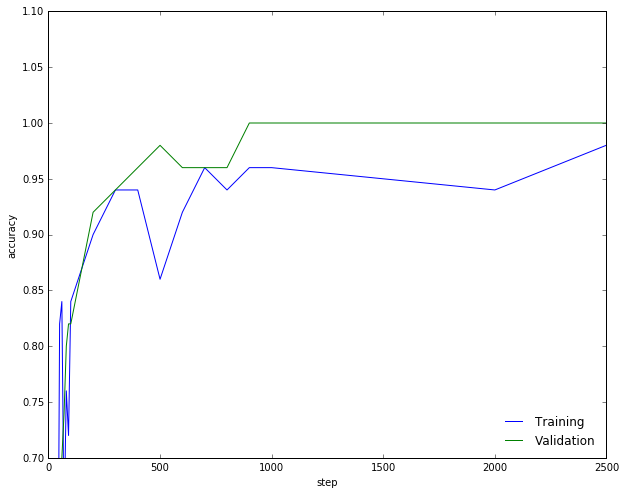

In [34]:
# check final accuracy on validation set  
if(VALIDATION_SIZE):
    validation_accuracy = accuracy.eval(feed_dict={x: X_test, 
                                                   y_: y_test, 
                                                   keep_prob: 1.0})
    print('validation_accuracy => %.4f'%validation_accuracy)
    plt.plot(x_range, train_accuracies,'-b', label='Training')
    plt.plot(x_range, validation_accuracies,'-g', label='Validation')
    plt.legend(loc='lower right', frameon=False)
    plt.ylim(ymax = 1.1, ymin = 0.7)
    plt.ylabel('accuracy')
    plt.xlabel('step')
    plt.show()

When, we're happy with the outcome, we read test data from test.csv and predict labels for provided images.  

Test data contains only images and labels are missing. Otherwise, the structure is similar to training data.  

Predicted labels are stored into CSV file for future submission.  

test_images(28000,784)
predicted_labels(28000)
predicted_labels[10] => 5.0


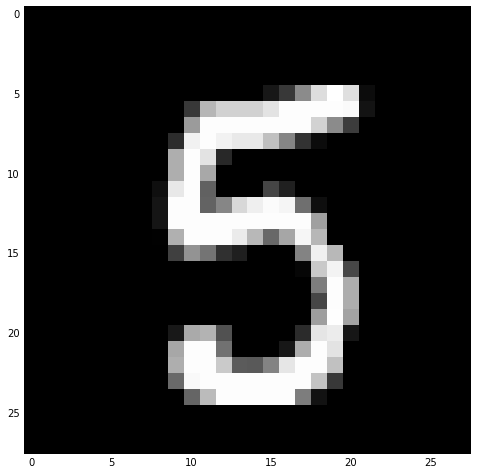

In [35]:
# read test data from CSV file 
test_images = pd.read_csv(os.path.join(datapath, "kaggle_digits_test.csv")).values
test_images = test_images.astype(np.float)

# convert from [0:255] => [0.0:1.0]
test_images = np.multiply(test_images, 1.0 / 255.0)

print('test_images({0[0]},{0[1]})'.format(test_images.shape))


# predict test set
#predicted_lables = predict.eval(feed_dict={x: test_images, keep_prob: 1.0})

# using batches is more resource efficient
predicted_labels = np.zeros(test_images.shape[0])
for i in range(0,test_images.shape[0]//BATCH_SIZE):
    predicted_labels[i*BATCH_SIZE : (i+1)*BATCH_SIZE] = predict.eval(feed_dict={x: test_images[i*BATCH_SIZE : (i+1)*BATCH_SIZE], 
                                                                                keep_prob: 1.0})


print('predicted_labels({0})'.format(len(predicted_labels)))

# output test image and prediction
plt.imshow(test_images[IMAGE_TO_DISPLAY].reshape((28, 28)))
print ('predicted_labels[{0}] => {1}'.format(IMAGE_TO_DISPLAY,predicted_labels[IMAGE_TO_DISPLAY]))

#### Appendix

As it was mentioned before, it is good to output some variables for a better understanding of the process.  

Here we pull an output of the first convolution layer from TensorFlow graph. 32 features are transformed into an image grid, and it's quite interesting to see how filters picked by NN outline characteristics of different digits.  

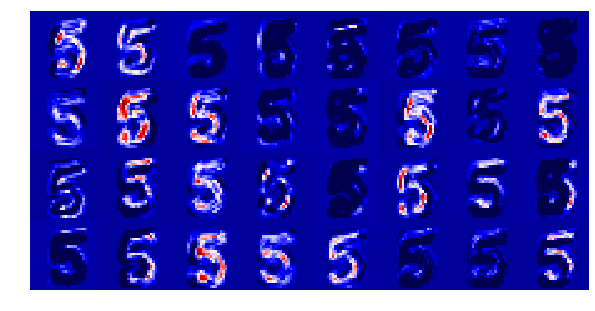

In [36]:
layer1_grid = layer1.eval(feed_dict={x: test_images[IMAGE_TO_DISPLAY:IMAGE_TO_DISPLAY+1], keep_prob: 1.0})
plt.axis('off')
plt.imshow(layer1_grid[0], cmap=cm.seismic )

In [37]:
sess.close()

### Using Theano and Lasagne

https://www.kaggle.com/kobakhit/digit-recognizer/digit-recognizer-in-python-using-cnn  

Resources:

[Convolutional Neural Networks (LeNet)](http://deeplearning.net/tutorial/lenet.html/ "Convolutional Neural Networks (LeNet)")

[CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/ "CS231n Convolutional Neural Networks for Visual Recognition")

[Tutorial: Training convolutional neural networks with nolearn](http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb/ "Tutorial: Training convolutional neural networks with nolearn")

[Using convolutional neural nets to detect facial keypoints tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/ "Using convolutional neural nets to detect facial keypoints tutorial")

[Deep learning – Convolutional neural networks and feature extraction with Python](http://blog.christianperone.com/2015/08/convolutional-neural-networks-and-feature-extraction-with-python/ "Deep learning – Convolutional neural networks and feature extraction with Python")

In [38]:
import lasagne
from lasagne import layers
#from lasagne.layers import helper
#from lasagne.layers import InputLayer, MaxPool2DLayer, DenseLayer, DropoutLayer, helper
#from lasagne.layers import Conv2DLayer as ConvLayer

from lasagne.updates import nesterov_momentum
#from lasagne.updates import adam

#from lasagne.nonlinearities import rectify, softmax

from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Quadro K4200 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python3.5/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python3.5/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [39]:
target = labels_flat.astype(np.uint8)
train = np.array(images).reshape((-1, 1, 28, 28)).astype(np.uint8)
test = np.array(test_data).reshape((-1, 1, 28, 28)).astype(np.uint8)

In [40]:
net1 = NeuralNet(
        layers=[('input', layers.InputLayer),
                ('hidden', layers.DenseLayer),
                ('output', layers.DenseLayer),
                ],
        # layer parameters:
        input_shape=(None,1,28,28),
        hidden_num_units=1000, # number of units in 'hidden' layer
        output_nonlinearity=lasagne.nonlinearities.softmax,
        output_num_units=10,  # 10 target values for the digits 0, 1, 2, ..., 9

        # optimization method:
        update=nesterov_momentum,
        update_learning_rate=0.0001,
        update_momentum=0.9,

        max_epochs=15,
        verbose=1,
        )

In [41]:
# Train the network
net1.fit(train, target)

# Neural Network with 795010 learnable parameters

## Layer information

  #  name    size
---  ------  -------
  0  input   1x28x28
  1  hidden  1000
  2  output  10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     2.30372     2.30134    1.00103      0.11695  1.11s
      2     2.30211     2.29983    1.00099      0.13016  1.11s
      3     2.30055     2.29836    1.00095      0.13563  1.04s
      4     2.29903     2.29693    1.00091      0.13873  1.04s
      5     2.29754     2.29552    1.00088      0.14170  1.12s
      6     2.29609     2.29415    1.00085      0.14658  0.98s
      7     2.29467     2.29279    1.00082      0.15312  1.00s
      8     2.29327     2.29146    1.00079      0.15443  0.98s
      9     2.29190     2.29015    1.00076      0.15753  1.04s
     10     2.29054     2.28886    1.00074      0.16145  1.05s
     11     2.28921     2.28758    1.00071      0.16550  1.05s
     12     2.2

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f0b654a2c18>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f0b654a2828>,
     check_input=True, custom_scores=None, hidden_num_units=1000,
     input_shape=(None, 1, 28, 28),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=15, more_params={},
     objective=<function objective at 0x7f0b6500bd90>,
     objective_loss_function=<function categorical_crossentropy at 0x7f0b64fe2488>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog object at 0x7f0b658d6ef0>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo object at 0x7f0b658d6e10>],
     output_nonlinearity=<function softmax at 0x7f0b65018d90>,
     output_num_units=10,

You can see the output associated with the training process. Right off the bat this set up gives us ~0.95 accuracy score in just 15 epochs which completes in less 3 minuts. Unfortunately, one layer neural network does not improve beyond 0.96 accuracy score ragardless of how many neurons in a layer is specified (1000 in case above).

I will try out the convolutional neural network. To set up the CNN I added two convolutional layers and one pooling layer. I would add another pooling layer and a dropout layer.

In [42]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],

    input_shape=(None, 1, 28, 28),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=1000,
    output_num_units=10, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(15).fit(train,target) # train the CNN model for 15 epochs

/usr/local/lib/python3.5/dist-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 1739428 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    1x28x28
  1  conv1    7x26x26
  2  pool1    7x13x13
  3  conv2    12x12x12
  4  hidden3  1000
  5  output   10

  epoch    trn loss    val loss    trn/val    valid acc  dur
-------  ----------  ----------  ---------  -----------  -----
      1     2.30124     2.30114    1.00005      0.12683  2.61s
      2     2.29995     2.29985    1.00004      0.14063  2.83s
      3     2.29865     2.29856    1.00004      0.14848  2.90s
      4     2.29736     2.29729    1.00003      0.14979  2.85s
      5     2.29608     2.29603    1.00002      0.15217  2.86s
      6     2.29480     2.29475    1.00002      0.15407  2.95s
      7     2.29351     2.29347    1.00002      0.15503  2.79s
      8     2.29221     2.29217    1.00002      0.15360  2.94s
      9     2.29089     2.29085    1.00002      0.15336  3.01s
     10     2.28954     2.28950    1.00002      0.15265  2.86s
    

Looks like this CNN model produces a slightly better result than a simple NN model for the same number of epochs and neurons in the hidden layer. The CNN model was more time consuming though. If you think that it is not worth it to use the CNN model over the NN you are wrong. NN model like any other has an upper bound on the best accuracy score it can produce. After 20 epochs NN model does not improve beyond ~0.97 whereas a CNN model gets closer to one.

So there you go. You have a starting point for using neural nets for image classification. If you expand on the info here and reach a score greater than 0.99 please drop a comment. Now, lets use it on the test set and save the results.

In [43]:
# use the NN model to classify test data
pred = cnn.predict(test)
pred[0:10]

array([0, 0, 8, 0, 3, 0, 0, 3, 0, 3])

### Using Keras  
https://keras.io/  
https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html  
https://keras.io/backend/#switching-from-one-backend-to-another  
https://www.kaggle.com/somshubramajumdar/digit-recognizer/deep-convolutional-network-using-keras  

In [44]:
import keras.layers.core as core
import keras.layers.convolutional as conv
import keras.models as models
import keras.utils.np_utils as kutils

Using Theano backend.


In [45]:
nb_epoch = 10 # Change to 100
batch_size = 128
img_rows, img_cols = 28, 28
nb_filters_1 = 32 # 64
nb_filters_2 = 64 # 128
nb_filters_3 = 128 # 256
nb_conv = 3

In [46]:
trainX = train_data.values[:, 1:].reshape(train_data.values.shape[0], 1, img_rows, img_cols)
trainX = trainX.astype(float)
trainX /= 255.0

trainY = kutils.to_categorical(train_data.values[:, 0])
nb_classes = trainY.shape[1]

In [47]:
cnn = models.Sequential()
cnn.add(conv.ZeroPadding2D((1,1), input_shape=(1, 28, 28),))
cnn.add(conv.Convolution2D(nb_filters_1, nb_conv, nb_conv,  activation="relu"))
#cnn.add(conv.ZeroPadding2D((1, 1)))
#cnn.add(conv.Convolution2D(nb_filters_1, nb_conv, nb_conv, activation="relu"))
cnn.add(conv.MaxPooling2D(strides=(2,2)))
cnn.add(conv.ZeroPadding2D((1, 1)))
cnn.add(conv.Convolution2D(nb_filters_2, nb_conv, nb_conv, activation="relu"))
#cnn.add(conv.ZeroPadding2D((1, 1)))
#cnn.add(conv.Convolution2D(nb_filters_2, nb_conv, nb_conv, activation="relu"))
cnn.add(conv.MaxPooling2D(strides=(2,2)))
#cnn.add(conv.ZeroPadding2D((1, 1)))
#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu"))
#cnn.add(conv.ZeroPadding2D((1, 1)))
#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu"))
#cnn.add(conv.ZeroPadding2D((1, 1)))
#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu"))
#cnn.add(conv.ZeroPadding2D((1, 1)))
#cnn.add(conv.Convolution2D(nb_filters_3, nb_conv, nb_conv, activation="relu"))
#cnn.add(conv.MaxPooling2D(strides=(2,2)))
cnn.add(core.Flatten())
cnn.add(core.Dropout(0.2))
cnn.add(core.Dense(128, activation="relu")) # 4096
cnn.add(core.Dense(nb_classes, activation="softmax"))
cnn.summary()
cnn.compile(loss="categorical_crossentropy", optimizer="adadelta", metrics=["accuracy"])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 1, 30, 30)     0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 28, 28)    320         zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 14, 14)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 32, 16, 16)    0           maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [48]:
cnn.fit(trainX, trainY, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1)

Epoch 1/10
42000/42000 [==============================] - 8s - loss: 0.3685 - acc: 0.8903     
Epoch 2/10
42000/42000 [==============================] - 8s - loss: 0.0970 - acc: 0.9699     
Epoch 3/10
42000/42000 [==============================] - 8s - loss: 0.0685 - acc: 0.9794     
Epoch 4/10
42000/42000 [==============================] - 8s - loss: 0.0559 - acc: 0.9830     
Epoch 5/10
42000/42000 [==============================] - 8s - loss: 0.0486 - acc: 0.9854     
Epoch 6/10
42000/42000 [==============================] - 8s - loss: 0.0419 - acc: 0.9876     
Epoch 7/10
42000/42000 [==============================] - 8s - loss: 0.0360 - acc: 0.9884     
Epoch 8/10
42000/42000 [==============================] - 8s - loss: 0.0322 - acc: 0.9903     
Epoch 9/10
42000/42000 [==============================] - 8s - loss: 0.0297 - acc: 0.9906     
Epoch 10/10
42000/42000 [==============================] - 8s - loss: 0.0262 - acc: 0.9916     


In [49]:
testX = test_data.reshape(test_data.shape[0], 1, 28, 28)
testX = testX.astype(float)
testX /= 255.0

In [50]:
yPred = cnn.predict_classes(testX)
yPred[0:10]

28000/28000 [==============================] - 3s     


array([2, 0, 9, 9, 3, 7, 0, 3, 0, 3])

TBD:
https://www.kaggle.com/lukasz8000/digit-recognizer/test1